In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  # Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


In [ ]:
!kaggle datasets download -d vencerlanz09/pharmaceutical-drugs-and-vitamins-synthetic-images

 98% 233M/238M [00:03<00:00, 115MB/s]
100% 238M/238M [00:03<00:00, 76.8MB/s]


In [ ]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten

<ipython-input-3-4addd0ae159c>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [ ]:
from zipfile import ZipFile
file_name = "/content/pharmaceutical-drugs-and-vitamins-synthetic-images.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
os.chdir('/content/Drug Vision/Data Combined/Biogesic')
x = []
y = []
for i in tqdm(os.listdir()):
      img = cv2.imread(i)
      img = cv2.resize(img,(128,128))
      x.append(img)
      y.append(0)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
os.chdir('/content/Drug Vision/Data Combined/Fish Oil')
for i in tqdm(os.listdir()):
      img = cv2.imread(i)
      img = cv2.resize(img,(128,128))
      x.append(img)
      y.append(1)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
len(x)

2000

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)

Shape of an image in X_train:  (128, 128, 3)
Shape of an image in X_test:  (128, 128, 3)


In [ ]:
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (1340, 128, 128, 3)
X_test Shape:  (660, 128, 128, 3)
y_train Shape:  (1340,)
y_test Shape:  (660,)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.4,
    fill_mode='nearest'
)

In [ ]:
train_generator = datagen.flow(X_train, y_train,batch_size=32)

In [ ]:
steps_per_epoch = len(train_generator)  # Calculate steps per epoch
for i in range(steps_per_epoch):
    X_train_aug, y_train_aug = train_generator.next()

In [ ]:
X_train = np.concatenate((X_train,X_train_aug))
y_train = np.concatenate((y_train,y_train_aug))

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

X_train shape:  (1368, 128, 128, 3)
y_train shape:  (1368,)


In [ ]:
from keras.applications import vgg16


img_rows, img_cols = 128, 128


vgg = vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (img_rows, img_cols, 3))

for layer in vgg.layers:
    layer.trainable = False

for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

58889256/58889256 [==============================] - 0s 0us/step
0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [ ]:

def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dropout(0.4)(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(num_classes,activation='sigmoid')(top_model)
    return top_model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model


num_classes = 1

FC_Head = lw(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = FC_Head)
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import backend as K
metrics = [
        'accuracy',
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.FalseNegatives(),
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.TruePositives(),]
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=metrics)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=4
    )
]
history = model.fit(X_train, y_train, epochs=7,batch_size=32,validation_split=0.3,callbacks=callbacks, shuffle=True)

Epoch 1/7
30/30 [==============================] - 236s 8s/step - loss: 2.1666 - accuracy: 0.5580 - auc_2: 0.5801 - recall_2: 0.5209 - precision_2: 0.5362 - false_negatives_2: 218.0000 - false_positives_2: 205.0000 - true_negatives_2: 297.0000 - true_positives_2: 237.0000 - val_loss: 0.8036 - val_accuracy: 0.5839 - val_auc_2: 0.7950 - val_recall_2: 0.9732 - val_precision_2: 0.5692 - val_false_negatives_2: 6.0000 - val_false_positives_2: 165.0000 - val_true_negatives_2: 22.0000 - val_true_positives_2: 218.0000
Epoch 2/7
30/30 [==============================] - 246s 8s/step - loss: 0.5879 - accuracy: 0.7262 - auc_2: 0.8112 - recall_2: 0.7451 - precision_2: 0.6990 - false_negatives_2: 116.0000 - false_positives_2: 146.0000 - true_negatives_2: 356.0000 - true_positives_2: 339.0000 - val_loss: 0.6093 - val_accuracy: 0.7275 - val_auc_2: 0.8530 - val_recall_2: 0.5625 - val_precision_2: 0.9000 - val_false_negatives_2: 98.0000 - val_false_positives_2: 14.0000 - val_true_negatives_2: 173.0000 - 

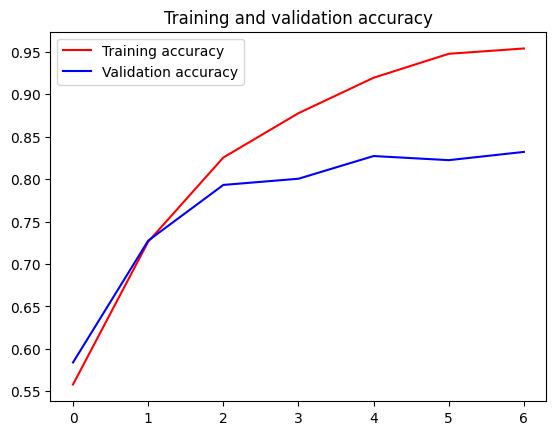

<Figure size 640x480 with 0 Axes>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

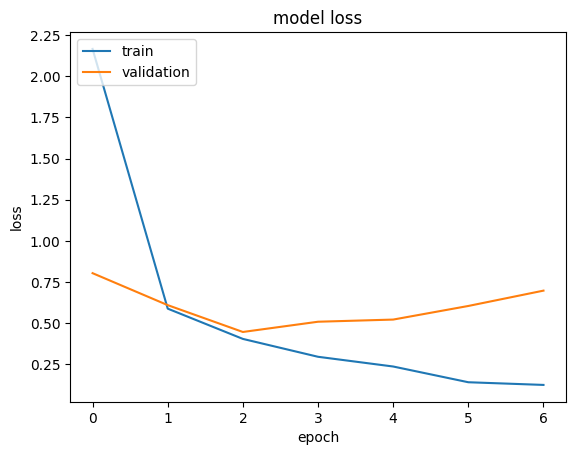

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

21/21 [==============================] - 113s 5s/step - loss: 0.5744 - accuracy: 0.8424 - auc_2: 0.9222 - recall_2: 0.8955 - precision_2: 0.8130 - false_negatives_2: 35.0000 - false_positives_2: 69.0000 - true_negatives_2: 256.0000 - true_positives_2: 300.0000


[0.5744113922119141,
 0.842424213886261,
 0.9222089052200317,
 0.89552241563797,
 0.8130081295967102,
 35.0,
 69.0,
 256.0,
 300.0]